# PM10 미세먼지 예측

[분석 기법]

 1. 그래프를 활용한 탐색적 분석
 2. 2 sample t test
 3. 다중선형회귀 분석
 4. 의사결정나무
 5. 랜덤 포레스트
 6. 그래디언트 부스팅

## 패기지 불러오기

In [163]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mpl
%matplotlib inline 
import matplotlib.font_manager as fm
from sklearn import datasets

from statsmodels.graphics.tsaplots import plot_predict
from sklearn.tree import export_graphviz 
import graphviz

import scipy.stats
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import statsmodels.api as sm
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neural_network import MLPClassifier
from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

font_fname = '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'
fontprop = fm.FontProperties(fname=font_fname, size=18).get_name()
matplotlib.rc('font',family= fontprop)
matplotlib.rc('axes',unicode_minus=False)
from statsmodels.api import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import mean_absolute_error
from skimage.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

## 데이터 불러오기

In [164]:
df_air = pd.read_csv("바탕화면/2. Big Data 분석/AIR_POLLUTION.csv", encoding = 'euc-kr', parse_dates=["MeasDate"])
df_air.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [165]:
df_air.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.000000,365.000000,365.000000,311.000000,365.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,33.421918,0.023600,0.026814,0.517042,0.003033,13.863798,0.381639,2.225301,209.450820,60.295082,1005.848907,0.022951,5.064016
std,15.937983,0.011896,0.010271,0.152820,0.000632,9.830280,1.122127,0.723171,70.735018,14.534983,8.126823,0.222361,2.986119
min,5.000000,0.002000,0.008000,0.300000,0.002000,-7.950000,0.000000,0.940000,50.000000,17.900000,983.800000,0.000000,0.000000
25%,22.000000,0.014000,0.019000,0.400000,0.003000,5.492500,0.000000,1.722500,160.250000,49.650000,999.400000,0.000000,2.510000
50%,31.000000,0.023000,0.025000,0.500000,0.003000,14.000000,0.000000,2.095000,221.000000,61.050000,1006.450000,0.000000,5.310000
75%,42.000000,0.032000,0.034000,0.600000,0.003000,23.070000,0.115000,2.620000,266.000000,69.950000,1011.575000,0.000000,7.570000
max,101.000000,0.062000,0.059000,1.000000,0.005000,31.720000,11.800000,5.880000,351.000000,95.000000,1025.500000,3.200000,10.000000


## 데이터 전처리

결측치를 조회했다. 목표 변수인 PM10은 걸측치 1개가 발견되었고, 나머지 값들은 평균값으로 대체 해줬다.

In [166]:
print(df_air.isnull().sum())

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64


In [167]:
#df_air['O3'] = df_air['O3'].fillna(df_air['O3'].mean())
#df_air["NO2"] = df_air["NO2"].fillna(df_air['NO2'].mean())
df_air["CO"] = df_air["CO"].fillna(df_air['CO'].mean())
#df_air["SO2"] = df_air["SO2"].fillna(df_air['SO2'].mean())

df_air = df_air.dropna()

print(df_air.isnull().sum())

MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64


# EDA

### 1. 그래프 분석

목표변수 분포 확인

In [168]:
def fun_plot_hist(data, var):
    plt.hist(data[data["RAIN"] >=  0.05][var], label = "비가옴", alpha = 0.5)
    plt.hist(data[data["RAIN"] <=  0.05][var], label = "비가오지 않음", alpha = 0.5)
    plt.legend()

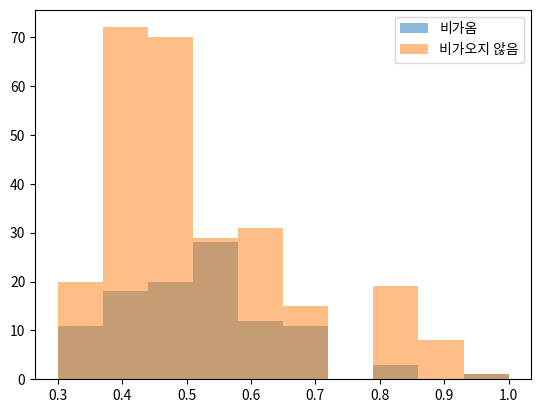

In [169]:
fun_plot_hist(df_air,"CO")

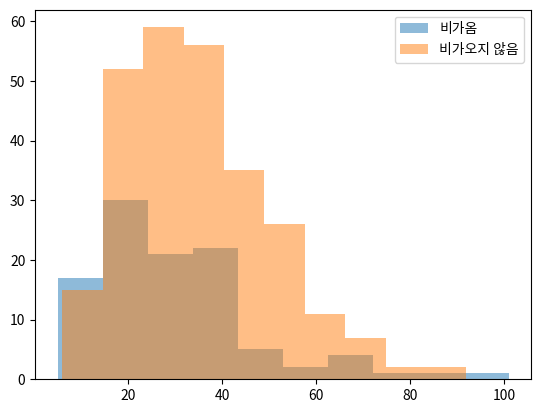

In [170]:
fun_plot_hist(df_air,"PM10")

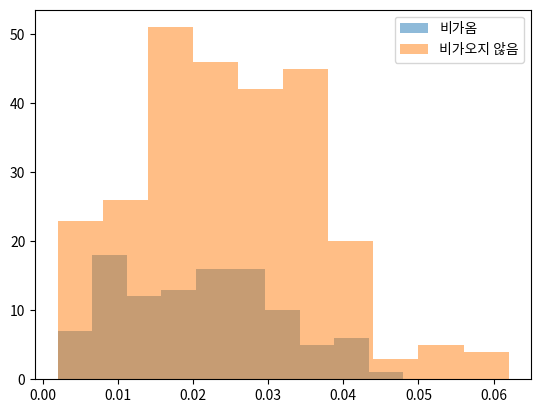

In [171]:
fun_plot_hist(df_air,"O3")

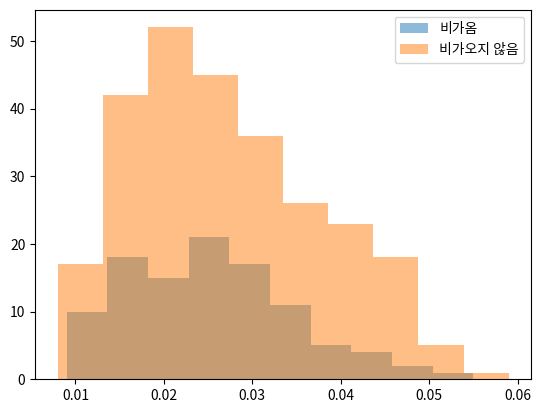

In [172]:
fun_plot_hist(df_air,"NO2")

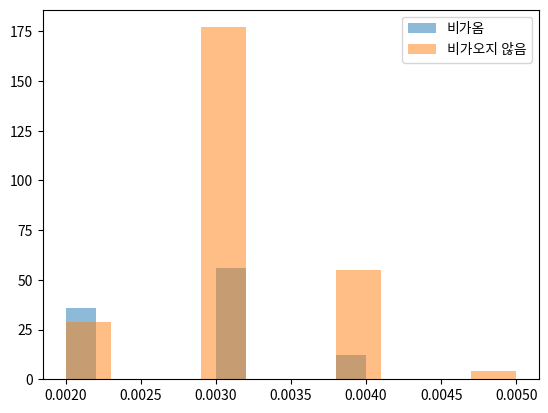

In [173]:
fun_plot_hist(df_air,"SO2")

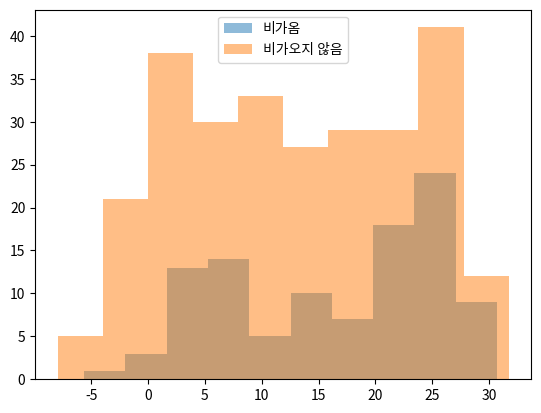

In [174]:
fun_plot_hist(df_air,"TEMP")

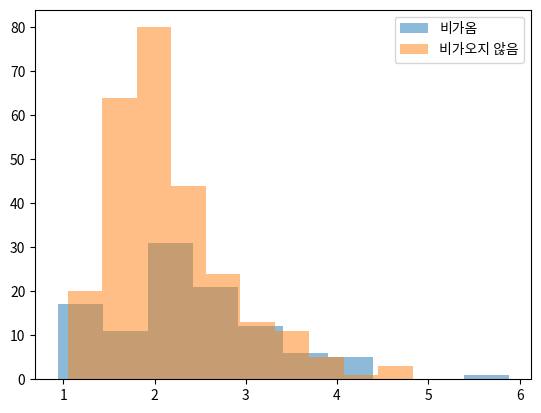

In [175]:
fun_plot_hist(df_air,"WIND")

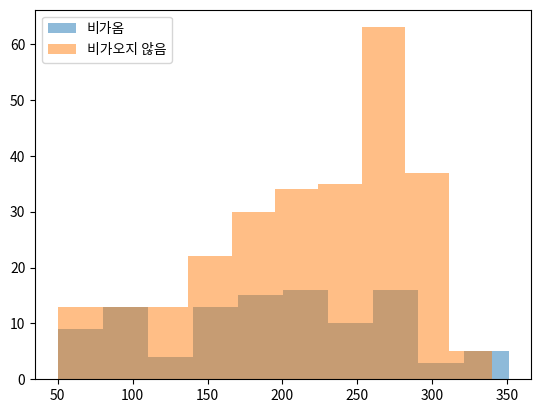

In [176]:
fun_plot_hist(df_air,"WIND_DIR")

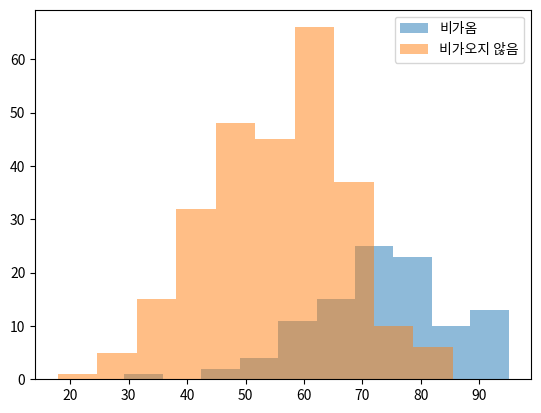

In [177]:
fun_plot_hist(df_air,"HUMIDITY")

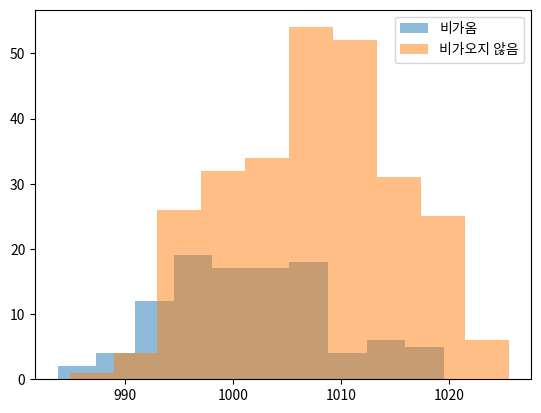

In [178]:
fun_plot_hist(df_air,"ATM_PRESS")

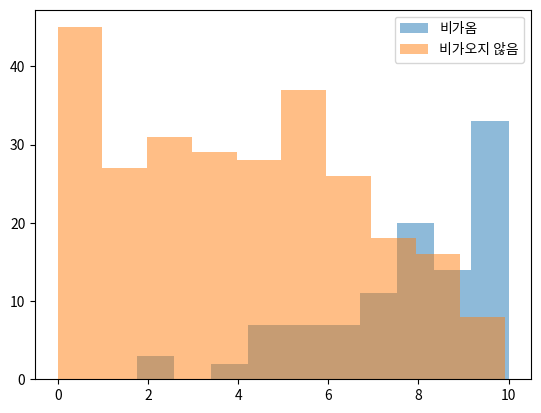

In [179]:
fun_plot_hist(df_air,"CLOUD")

설명변수와 목표변수간 관계확인

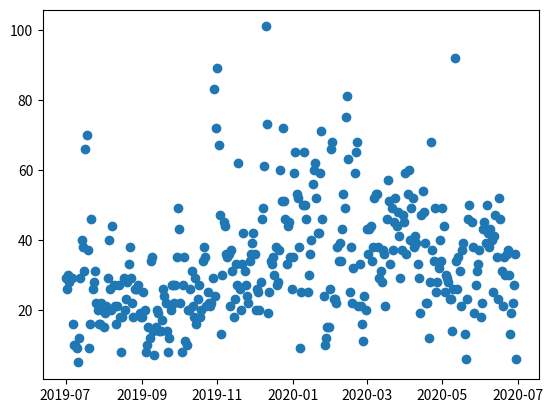

In [180]:
plt.scatter(df_air['MeasDate'], df_air['PM10'])
# 2019년 11월 이후 부터 2020년 사이에 무슨일이 있는 지 미세먼지가 증가함

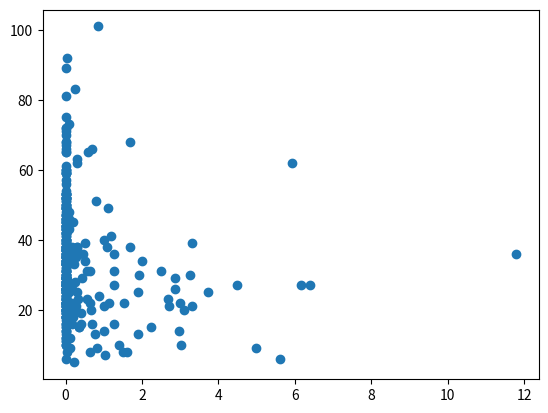

In [181]:
plt.scatter(df_air['RAIN'], df_air['PM10'])

# 비가 오지 않을 때 미세먼지가 공기중에 가장 많이 존재하고 비가 올 때 미세먼지가 없거나 훨씬 적은 양으로 존재한다.

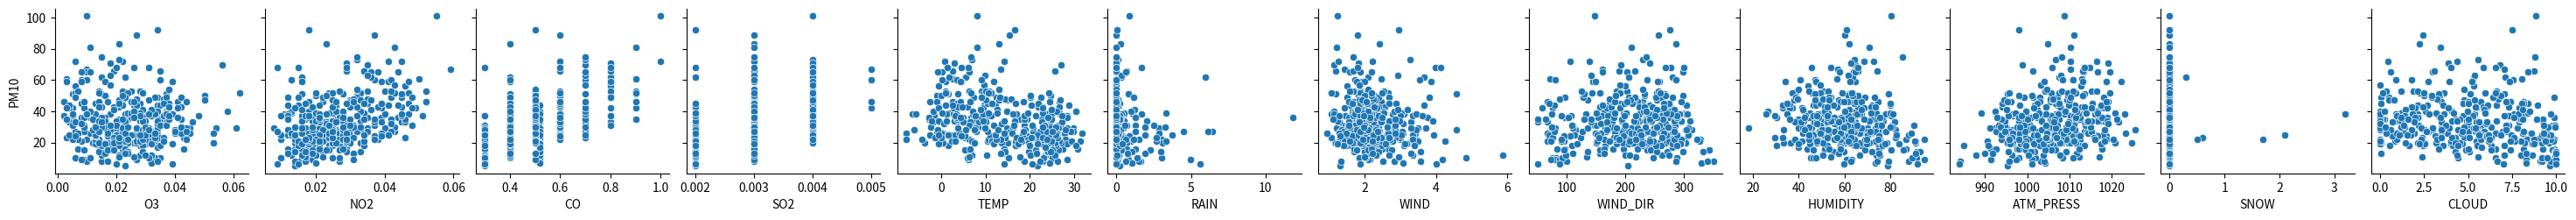

In [182]:
sns.pairplot(df_air,y_vars= 'PM10', x_vars= ['O3','NO2','CO','SO2','TEMP','RAIN','WIND','WIND_DIR','HUMIDITY','ATM_PRESS','SNOW','CLOUD'], diag_kind= 'hist')

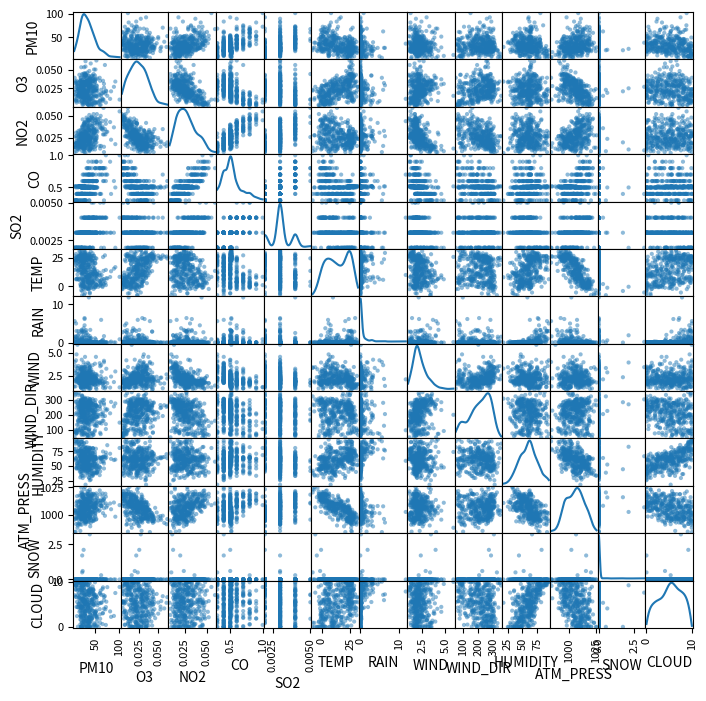

In [183]:
scatter_matrix(df_air, alpha= 0.5,figsize=(8,8), diagonal= 'kde')
plt.show()

설명변수 파생변수와 목표변수간 분포 차이 확인

<AxesSubplot:title={'center':'PM10'}, xlabel='[RAIN]'>

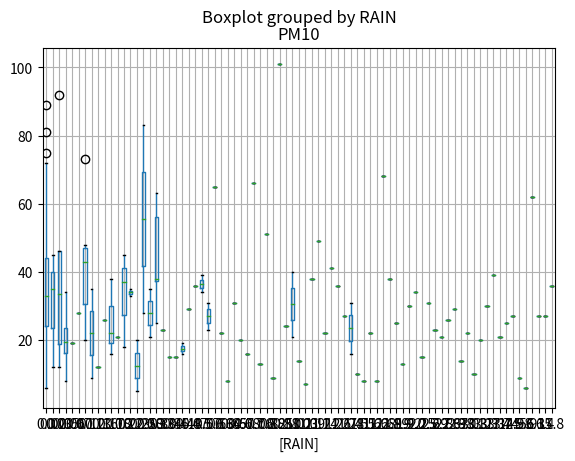

In [184]:
df_air.boxplot(column='PM10', by =['RAIN'])

상관 분석결과 확인

<AxesSubplot:>

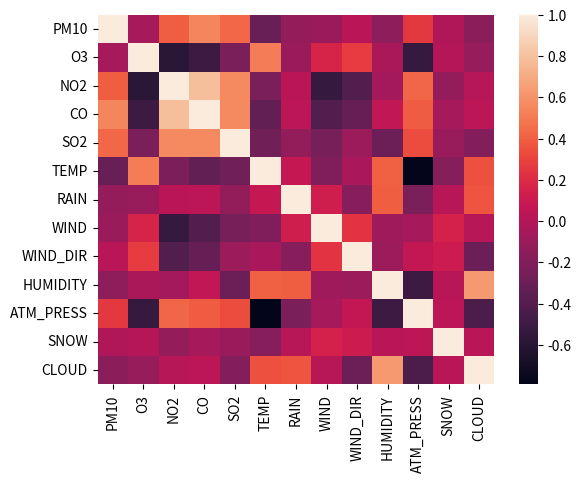

In [185]:
x = df_air.corr().round(3)
sns.heatmap(x)

In [186]:
print(len(df_air[df_air['SNOW']>0.05]))
print(len(df_air[df_air['RAIN']>0.05]))

6
100


In [187]:
df_air.columns

Index(['MeasDate', 'PM10', 'O3', 'NO2', 'CO', 'SO2', 'TEMP', 'RAIN', 'WIND',
       'WIND_DIR', 'HUMIDITY', 'ATM_PRESS', 'SNOW', 'CLOUD'],
      dtype='object')

In [188]:
df_air_RainDrop = df_air[df_air['RAIN']>0.5]

df_air_RainDrop_PM10 = df_air_RainDrop[['PM10', 'O3', 'NO2', 'CO', 'SO2', 'TEMP','WIND',
       'WIND_DIR', 'HUMIDITY', 'ATM_PRESS','CLOUD']]

In [189]:
df_air_RainDrop_PM10.head(10)


,PM10,O3,NO2,CO,SO2,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD
9,9.0,0.027,0.019,0.300000,0.002,22.79,2.13,80,61.0,997.3,8.29
14,38.0,0.031,0.034,0.600000,0.002,23.87,1.05,133,77.9,996.9,7.58
15,31.0,0.035,0.028,0.500000,0.002,24.36,1.38,152,80.8,1000.6,7.29
16,66.0,0.035,0.029,0.600000,0.003,25.54,1.18,189,74.5,1001.3,8.75
24,31.0,0.013,0.030,0.300000,0.002,26.35,1.25,148,90.5,994.7,9.79
25,22.0,0.021,0.027,0.517042,0.002,25.06,1.72,187,94.9,993.9,9.88
27,16.0,0.018,0.019,0.517042,0.002,26.31,2.00,179,87.1,998.0,9.88
30,20.0,0.016,0.025,0.517042,0.002,25.87,2.30,195,91.3,998.9,9.58
31,15.0,0.014,0.020,0.517042,0.002,26.41,1.70,237,85.8,1001.8,7.42
33,21.0,0.033,0.029,0.517042,0.002,29.40,1.36,152,70.6,1001.1,4.29


In [190]:
v_feature_names = df_air_RainDrop_PM10.columns

sc = StandardScaler()
df_scaled_Drop = sc.fit_transform(df_air_RainDrop_PM10)
df_scaled_Drop =pd.DataFrame(df_scaled_Drop, columns= v_feature_names)
df_scaled_Drop.head()

,PM10,O3,NO2,CO,SO2,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD
0,-1.070691,0.708057,-0.816834,-1.774187,-1.120035,0.630905,-0.273457,-1.264438,-1.571775,-0.449669,0.000341
1,0.560509,1.111649,0.752589,0.579520,-1.120035,0.750122,-1.531603,-0.588953,0.030438,-0.504233,-0.460252
2,0.166771,1.515241,0.124820,-0.205049,-1.120035,0.804211,-1.147170,-0.346798,0.305373,0.000479,-0.648382
3,2.135460,1.515241,0.229448,0.579520,0.437087,0.934466,-1.380160,0.124767,-0.291901,0.095965,0.298754
4,0.166771,-0.704516,0.334076,-1.774187,-1.120035,1.023879,-1.298613,-0.397778,1.224986,-0.804331,0.973426


비가오지 않을때

In [191]:
df_air_RainNot = df_air[df_air['RAIN']<=0.5]

df_air_RainNot_PM10 = df_air_RainNot[['PM10', 'O3', 'NO2', 'CO', 'SO2', 'TEMP','WIND',
       'WIND_DIR', 'HUMIDITY', 'ATM_PRESS','CLOUD']]

In [192]:
df_air_RainNot_PM10.head(10)

,PM10,O3,NO2,CO,SO2,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD
0,29.0,0.054,0.021,0.5,0.003,24.03,2.30,249,63.2,995.1,5.70
1,26.0,0.053,0.020,0.5,0.003,24.29,2.26,265,63.2,998.6,3.83
2,30.0,0.042,0.023,0.4,0.003,24.18,1.79,280,65.3,998.3,6.29
3,28.0,0.034,0.026,0.4,0.003,25.35,2.04,263,58.6,996.6,2.54
4,29.0,0.045,0.035,0.5,0.003,27.30,1.45,175,45.5,993.5,3.92
5,29.0,0.043,0.032,0.5,0.003,29.87,1.54,80,39.7,993.7,3.50
6,16.0,0.043,0.014,0.3,0.002,26.86,2.27,83,43.5,997.5,6.58
7,10.0,0.035,0.019,0.3,0.002,25.13,1.96,76,45.3,997.9,6.58
8,10.0,0.033,0.019,0.4,0.002,25.11,1.84,81,46.3,996.7,4.42
10,5.0,0.023,0.014,0.3,0.002,21.79,1.30,204,79.0,995.2,9.63


In [193]:
v_feature_names = df_air_RainNot_PM10.columns

sc = StandardScaler()
df_scaled_Not = sc.fit_transform(df_air_RainNot_PM10)
df_scaled_Not =pd.DataFrame(df_scaled_Not, columns= v_feature_names)
df_scaled_Not.head()

,PM10,O3,NO2,CO,SO2,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD
0,-0.353225,2.458858,-0.560162,-0.107322,-0.148483,1.093673,0.148340,0.503765,0.485325,-1.490074,0.445071
1,-0.548779,2.376153,-0.656494,-0.107322,-0.148483,1.120071,0.090470,0.740086,0.485325,-1.045915,-0.224442
2,-0.288040,1.466400,-0.367499,-0.806079,-0.148483,1.108903,-0.589510,0.961637,0.650289,-1.083986,0.656307
3,-0.418409,0.804761,-0.078504,-0.806079,-0.148483,1.227690,-0.227818,0.710546,0.123977,-1.299720,-0.686298
4,-0.353225,1.714514,0.788480,-0.107322,-0.148483,1.425670,-1.081409,-0.589220,-0.905079,-1.693118,-0.192219


## 2-sample t-Test, 맨 휘트니 유 검정

2 sample t Test를 하기위해 정규성을 정검한다. 정규성 검정 결과 pvalue가 0.05보다 크면 졍규  작으면 비정규

In [194]:
statisic,p = stats.shapiro(df_air_RainNot['PM10'])
print("statistics = {}, p-value = {}".format(statisic,p))

statistics = 0.9559236764907837, p-value = 5.2222841162574696e-08


In [195]:
statisic,p = stats.shapiro(df_air_RainDrop['PM10'])
print("statistics = {}, p-value = {}".format(statisic,p))

statistics = 0.8578070402145386, p-value = 8.282932867587078e-06


비가 올때와 오지 않을때 모드 정규성을 띄지 않는다. 그렇기 때문에 2 sample  t test를 사용하지 않고 맨 휘트니 검정 사용

In [196]:
statisic,p = stats.mannwhitneyu(df_scaled_Drop['PM10'], df_scaled_Drop["RAIN"])
print(" Rain Drop statistics = {}, p-value = {}".format(statisic,p))

statisic,p = stats.mannwhitneyu(df_scaled_Not['PM10'], df_scaled_Not['RAIN'])
print("Rain Not statistics = {}, p-value = {}".format(statisic,p))

KeyError: 'RAIN'

귀무 : 비가 오는 상황에서 미세먼지와 비가오는 상황과 관련이 있다.

대립 : 비가 오는 상황에서 미세먼지와 비가오는 상황과 관련이 없다.

귀무 : 비가 오지않는 상황에서 미세먼지와 비가오지 않는 상황과 관련이 있다.

대립 : 비가 오지않는 상황에서 미세먼지와 비가오지 않는 상황과 관련이 없다.

## 다중선형회귀 

정규성을 만족하지 않기 때문에 다중성형회귀를 하지 않는다.

## 의사결정 나무

랜덤포레스트를 진행하기 때문에 하지 않는다.

# 랜덤포레스트

## 비가 내릴때

In [197]:
df_scaled_Drop.isnull().sum(axis = 0)

PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
CLOUD        0
dtype: int64

데이터는 (train(0.6) : test(0.4) )의 비율로 분할 (train_test_split 활용)

In [198]:
# 설명변수, 목표변수 데이터 지정
df_raw_x = df_air_RainDrop_PM10.drop("PM10", axis = 1, inplace = False)
df_raw_y = df_air_RainDrop_PM10["PM10"] 

# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.4, # test 데이터의 비율
                                                                random_state = 1234)  # random state                                                             

## 모델 생성

기본 옵션 모델

In [199]:
# 랜덤 포레스트 모델 생성: RandomForestClassifier
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.883
Accuracy on test set: 0.253


## 생성 트리수 조정에 따른 정확도 변화

In [200]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 1~150
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [201]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.859,0.264
1,20,0.893,0.262
2,30,0.894,0.251
3,40,0.890,0.261
4,50,0.892,0.260
5,60,0.885,0.266
6,70,0.886,0.261
7,80,0.889,0.253
8,90,0.890,0.256
9,100,0.883,0.253


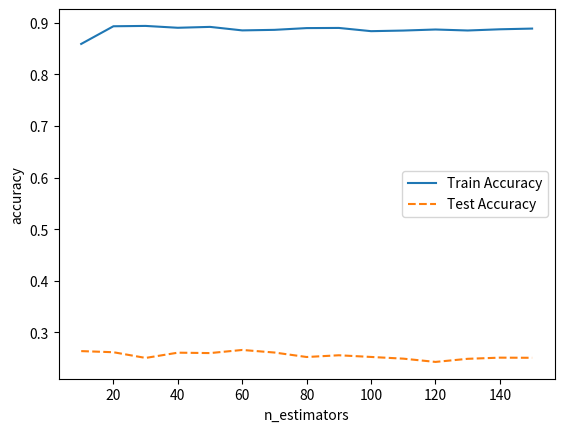

In [202]:
# 모델 정확도 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()

#### n_estimators: 트리의 개수 변경 시 모델의 oob error 변화

In [203]:
# error 저장 리스트
oob_error = []

for v_n_estimator in range(1, 151):
    rf = RandomForestRegressor(n_estimators = v_n_estimator, oob_score = True, random_state= 1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1 - rf.oob_score_)

/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do no

Text(0.5, 0, 'n_estimators')

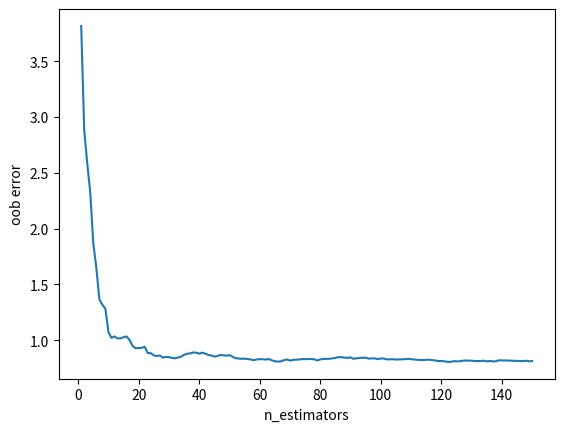

In [204]:
# 그래프로 표현
plt.plot(range(1, 151), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

트리의 개수가 100개 이상부터 급격하게 oob error가 줄어들고 있는 것을 확인 할 수 있다.

In [205]:
# 임의로 지정
n_estimators = 40

최대 깊이 조정에 따른 정확도 변화

In [206]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(max_depth = v_max_depth, n_estimators=40, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [207]:
# 모델 정확도 확인
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.462,0.219
1,2,0.702,0.248
2,3,0.815,0.266
3,4,0.868,0.271
4,5,0.883,0.288
5,6,0.890,0.251
6,7,0.890,0.257
7,8,0.887,0.246
8,9,0.889,0.263
9,10,0.890,0.261


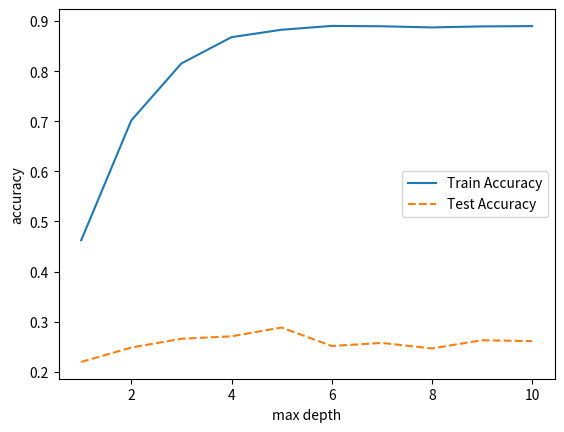

In [208]:
# 모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max depth"); plt.ylabel("accuracy")
plt.legend()

In [209]:
max_depth = 3

In [210]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수. 10~100
para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(min_samples_split = v_min_samples_split, max_depth=3,
                                n_estimators=40, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [211]:
# 테이블 결과
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.656,0.244
1,20,0.464,0.218
2,30,-0.000,-0.018
3,40,-0.000,-0.018
4,50,-0.000,-0.018
5,60,-0.000,-0.018
6,70,-0.000,-0.018
7,80,-0.000,-0.018
8,90,-0.000,-0.018
9,100,-0.000,-0.018


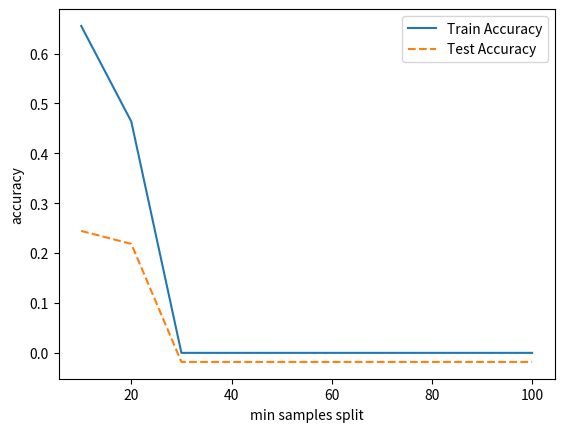

In [212]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split"); plt.ylabel("accuracy")
plt.legend()

분리 노드의 최소 샘플수가 증가에 따라 모델의 설명력은 감소하며 train/test 데이터의 성능 변화를 고려하여 20선택

### min_samples_leaf(최소 잎사귀 수) 조정에 따른 정확도 변화

In [213]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(min_samples_leaf = v_min_samples_leaf,min_samples_split = 20,
                                max_depth=3, n_estimators=40, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [214]:
# 테이블 결과
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.451,0.205
1,10,0.312,0.060
2,15,-0.000,-0.018
3,20,-0.000,-0.018
4,25,-0.000,-0.018
5,30,-0.000,-0.018
6,35,-0.000,-0.018
7,40,-0.000,-0.018
8,45,-0.000,-0.018
9,50,-0.000,-0.018


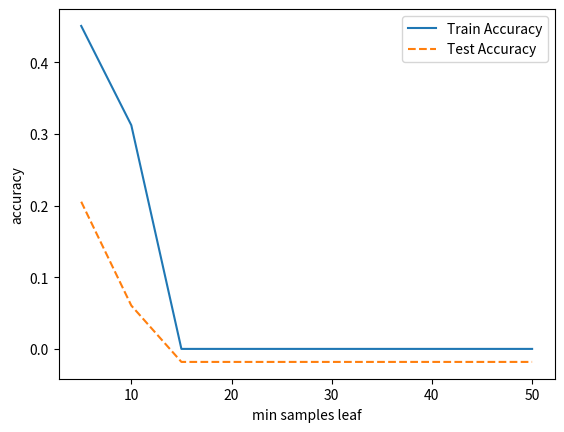

In [215]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples leaf"); plt.ylabel("accuracy")
plt.legend()

최소 잎사귀 수가 증가할수록 train정확도는 떨어지고 있으며 test 정확도는 일정하기에 20 이후로는 의미가 없다고 판단 10 선택

최종 모델

In [216]:
# 최종 모델
rf_final = RandomForestRegressor(min_samples_leaf=10, max_depth=3, n_estimators=40,min_samples_split = 20,
                                  random_state=1234)
rf_final.fit(df_train_x, df_train_y)
# 평가
y_pred = rf_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))


Accuracy on training set: 0.312
Accuracy on test set: 0.060



In [217]:
# 변수명
v_feature_names = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
1,NO2,0.541
7,HUMIDITY,0.108
2,CO,0.081
5,WIND,0.081
4,TEMP,0.054
9,CLOUD,0.054
0,O3,0.027
6,WIND_DIR,0.027
8,ATM_PRESS,0.027
3,SO2,0.000


Text(0, 0.5, '설명변수')

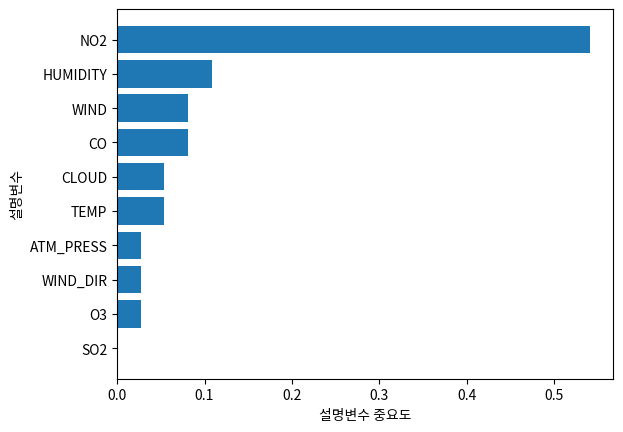

In [218]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 비가 내리지 않을때

In [219]:
# 설명변수, 목표변수 데이터 지정
df_raw_x = df_air_RainNot_PM10.drop("PM10", axis = 1, inplace = False)
df_raw_y = df_air_RainNot_PM10["PM10"] 

# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.2, # test 데이터의 비율
                                                                random_state = 1234)  # random state

모델 생성

기본 옵션 모델

In [220]:
# 랜덤 포레스트 모델 생성: RandomForestClassifier
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.916
Accuracy on test set: 0.506


생성 트리수 조정에 따른 정확도 변화

In [221]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 1~150
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [222]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.880,0.443
1,20,0.893,0.483
2,30,0.904,0.502
3,40,0.911,0.516
4,50,0.907,0.524
5,60,0.914,0.511
6,70,0.914,0.503
7,80,0.914,0.503
8,90,0.915,0.501
9,100,0.916,0.506


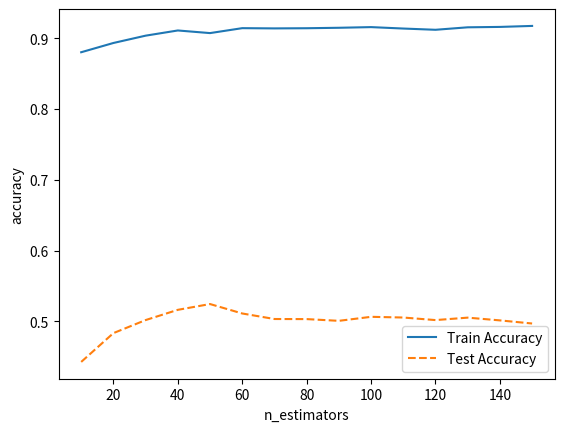

In [223]:
# 모델 정확도 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()

n_estimators: 트리의 개수 변경 시 모델의 oob error 변화

In [224]:
# error 저장 리스트
oob_error = []

for v_n_estimator in range(1, 151):
    rf = RandomForestRegressor(n_estimators = v_n_estimator, oob_score = True, random_state= 1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1 - rf.oob_score_)

/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do no

Text(0.5, 0, 'n_estimators')

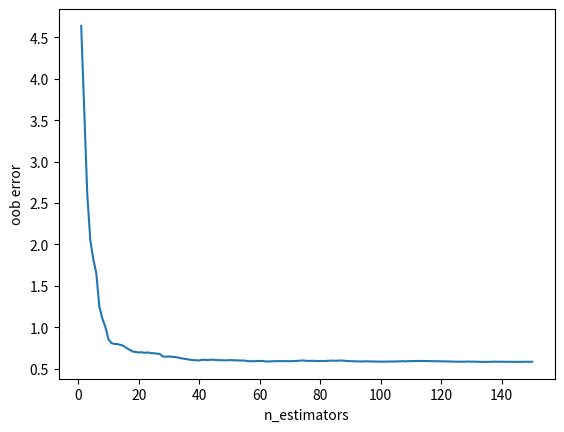

In [225]:
# 그래프로 표현
plt.plot(range(1, 151), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

트리의 개수가 3개 이상부터 급격하게 oob error가 줄어들고 있는 것을 확인 할 수 있다.

In [226]:
# 임의로 지정
n_estimators = 30

In [227]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(max_depth = v_max_depth, n_estimators=30, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [228]:
# 모델 정확도 확인
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.283,0.302
1,2,0.406,0.345
2,3,0.548,0.401
3,4,0.662,0.452
4,5,0.754,0.459
5,6,0.813,0.498
6,7,0.855,0.477
7,8,0.881,0.487
8,9,0.891,0.497
9,10,0.896,0.502


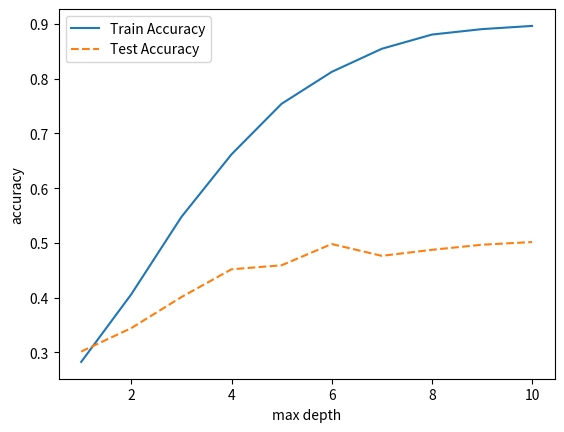

In [229]:
# 모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max depth"); plt.ylabel("accuracy")
plt.legend()

최대 깊이가 8 이상부터 train 정확도와 test 정확도가 일정하기 때문에 깊이는 를 선택

분할 노드의 최소 샘플 수 조정에 따른 정확도 변화

In [230]:
max_depth = 8

In [231]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수. 10~100
para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(min_samples_split = v_min_samples_split, max_depth=8,
                                n_estimators=30, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [232]:
# 테이블 결과
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.795,0.492
1,20,0.687,0.480
2,30,0.599,0.431
3,40,0.539,0.407
4,50,0.456,0.379
5,60,0.438,0.372
6,70,0.418,0.361
7,80,0.394,0.343
8,90,0.383,0.335
9,100,0.375,0.329


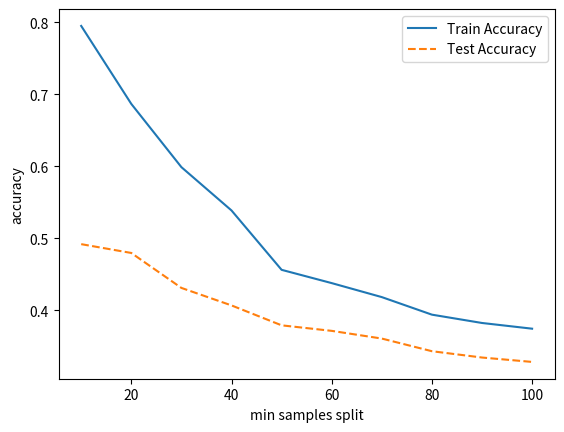

In [233]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split"); plt.ylabel("accuracy")
plt.legend()

분리 노드의 최소 샘플수가 증가에 따라 모델의 설명력은 감소하며 train/test 데이터의 성능 변화를 고려하여 20선택

min_samples_leaf(최소 잎사귀 수) 조정에 따른 정확도 변화

In [234]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(min_samples_leaf = v_min_samples_leaf,min_samples_split =20,
                                max_depth=8, n_estimators=30, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [235]:
# 테이블 결과
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.650,0.491
1,10,0.612,0.490
2,15,0.510,0.439
3,20,0.457,0.412
4,25,0.389,0.353
5,30,0.364,0.326
6,35,0.345,0.324
7,40,0.333,0.326
8,45,0.317,0.288
9,50,0.261,0.235


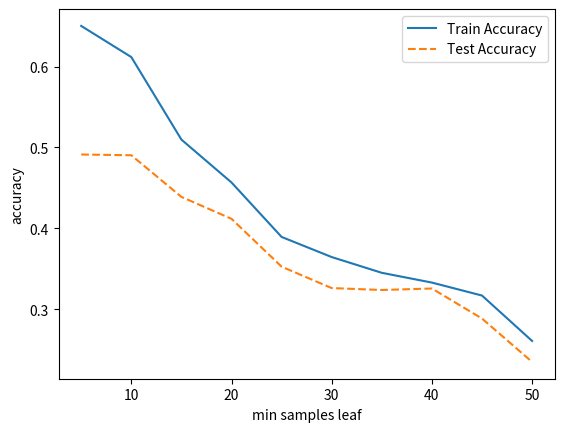

In [236]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples leaf"); plt.ylabel("accuracy")
plt.legend()

최소 잎사귀 수가 증가할수록 train정확도는 떨어지고 있으며 test 정확도는 일정하기에 20 이후로는 의미가 없다고 판단 10 선택

In [237]:
# 최종 모델
rf_final = RandomForestRegressor(min_samples_leaf=10, max_depth=8, n_estimators=30, min_samples_split = 20,
                                  random_state=1234)
rf_final.fit(df_train_x, df_train_y)
# 평가
y_pred = rf_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))

Accuracy on training set: 0.612
Accuracy on test set: 0.490



In [238]:
# 변수명
v_feature_names = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
2,CO,0.563
0,O3,0.118
4,TEMP,0.097
6,WIND_DIR,0.046
8,ATM_PRESS,0.044
9,CLOUD,0.042
1,NO2,0.033
5,WIND,0.032
7,HUMIDITY,0.022
3,SO2,0.003


Text(0, 0.5, '설명변수')

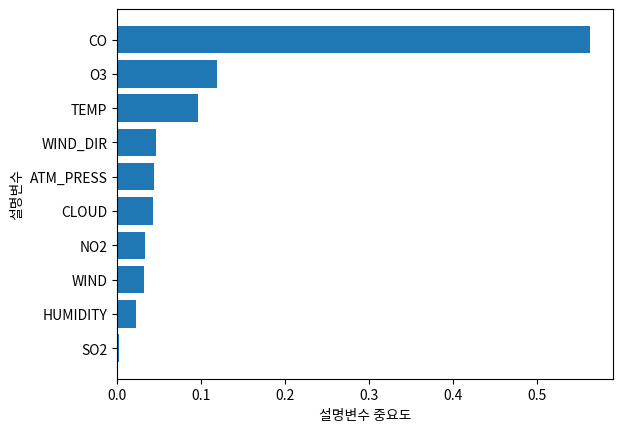

In [239]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 그래디언트 부스팅

## 비가 올때

In [240]:
# 설명변수, 목표변수 데이터 지정
df_raw_x = df_air_RainDrop_PM10.drop("PM10", axis = 1, inplace = False)
df_raw_y = df_air_RainDrop_PM10["PM10"] 

# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.4, # test 데이터의 비율
                                                                random_state = 1234,shuffle= True)  # random state

In [241]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncustomized.score (df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score (df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.190


In [242]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경: 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]
# para_lr = [lr * 0.02 for lr in range(1, 20)]   # 민감하게 변화하면 0.02 간격으로 확인

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

In [243]:
# LearningRate별 정확도 테이블
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,1.0,0.190
1,0.2,1.0,0.207
2,0.3,1.0,0.160
3,0.4,1.0,0.146
4,0.5,1.0,0.161
5,0.6,1.0,0.215
6,0.7,1.0,0.119
7,0.8,1.0,0.132
8,0.9,1.0,0.199


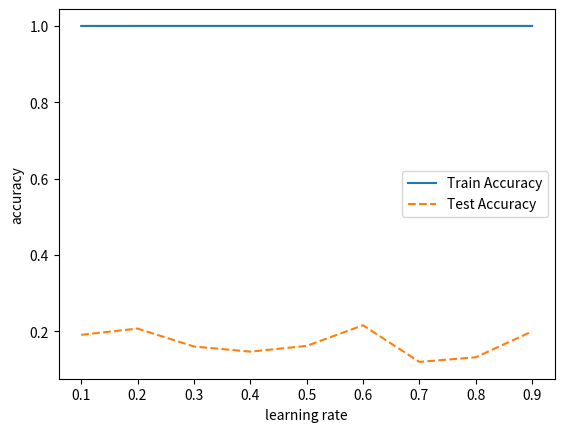

In [244]:
# LearningRate별 정확도 그래프로 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

In [245]:
# 학습률 지정
learing_rate = 0.2

n_estimators: 트리의 개수 변경에 따른 모델의 정확도 확인

In [246]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 10~150
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators = v_n_estimators, learning_rate=0.2, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [247]:
# n_estimators별 정확도 테이블
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.950,0.202
1,20,0.994,0.209
2,30,0.999,0.210
3,40,1.000,0.206
4,50,1.000,0.206
5,60,1.000,0.207
6,70,1.000,0.207
7,80,1.000,0.207
8,90,1.000,0.207
9,100,1.000,0.207


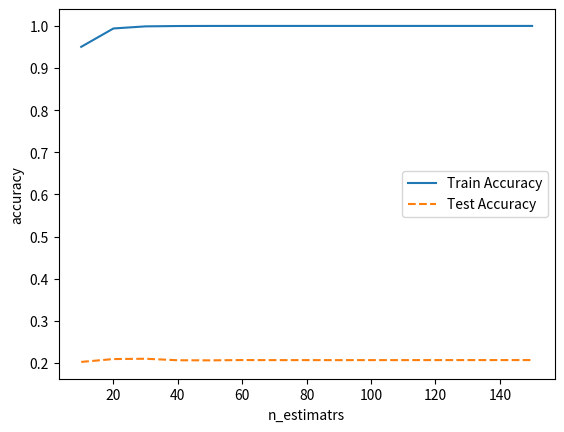

In [248]:
# 정확도를 그래프로 표현
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimatrs")
plt.legend()

In [249]:
# 트리 수 지정
n_estimators = 20

In [250]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경. 1~10
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(max_depth = v_max_depth,
                                    n_estimators=20, learning_rate=0.2, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [251]:
# max_depth별 정확도 테이블
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.711,0.198
1,2,0.964,0.242
2,3,0.994,0.209
3,4,0.999,0.203
4,5,1.000,0.174
5,6,1.000,0.103
6,7,1.000,0.103
7,8,1.000,0.100
8,9,1.000,0.103
9,10,1.000,0.103


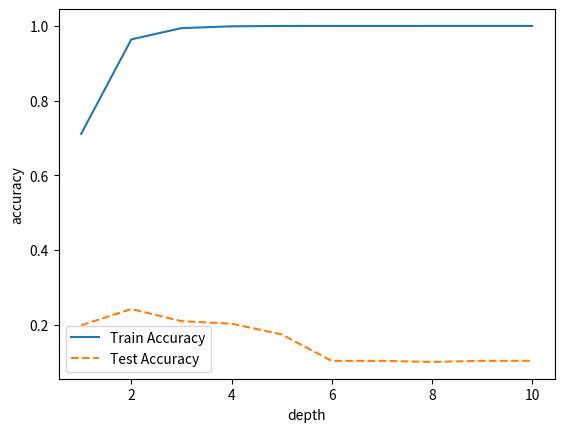

In [252]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

In [253]:
# 최대 깊이 지정
max_depth = 3

In [254]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수. 20~100
para_split = [n_split * 10 for n_split in range(2, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(min_samples_split = v_min_samples_split,
                                    max_depth=3, n_estimators=20, learning_rate=0.2, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [255]:
# min_samples_leaf별 정확도 테이블
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.874,0.196
1,30,0.818,0.220
2,40,0.000,-0.019
3,50,0.000,-0.019
4,60,0.000,-0.019
5,70,0.000,-0.019
6,80,0.000,-0.019
7,90,0.000,-0.019
8,100,0.000,-0.019


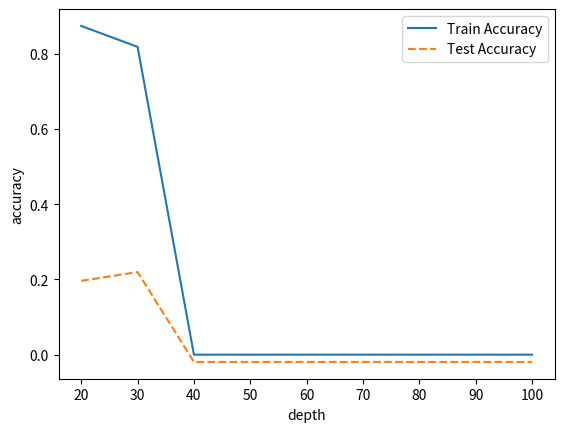

In [256]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

30선택


min_samples_leaf: leaf 수 변경에 따른 모델의 정확도 확인

In [257]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 노드 최소 자료 수. 5~50
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(min_samples_leaf = v_min_samples_leaf,min_samples_split = 30,
                                     max_depth=3, n_estimators=20, learning_rate=0.2, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [258]:
# min_samples_leaf별 정확도 테이블
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.637,0.218
1,10,0.615,0.203
2,15,0.498,0.036
3,20,0.000,-0.019
4,25,0.000,-0.019
5,30,0.000,-0.019
6,35,0.000,-0.019
7,40,0.000,-0.019
8,45,0.000,-0.019
9,50,0.000,-0.019


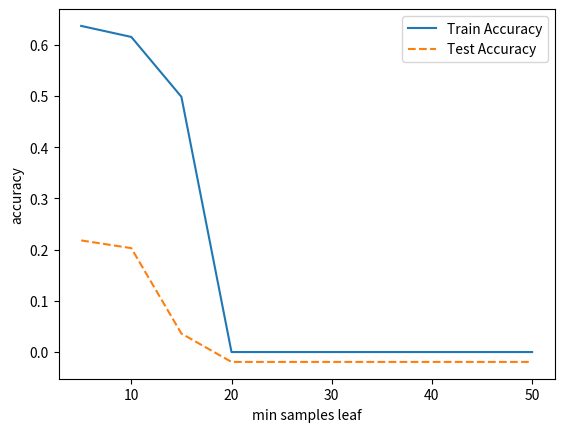

In [259]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()

In [260]:
# 잎사귀 노드의 최소 자료 수 지정
min_samples_leaf = 10

결론 도출
최종 모델 선택

In [261]:
# 최종 모델
gb_final = GradientBoostingRegressor(min_samples_leaf=10, max_depth=3, n_estimators=20, learning_rate=0.2, 
                                      random_state=1234)
gb_final.fit(df_train_x, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))

Accuracy on training set: 0.701
Accuracy on test set: 0.088



In [262]:
# 변수명
v_feature_name = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
2,CO,0.457
1,NO2,0.147
9,CLOUD,0.131
0,O3,0.107
6,WIND_DIR,0.087
7,HUMIDITY,0.068
4,TEMP,0.004
3,SO2,0.000
5,WIND,0.000
8,ATM_PRESS,0.000


Text(0, 0.5, '설명변수')

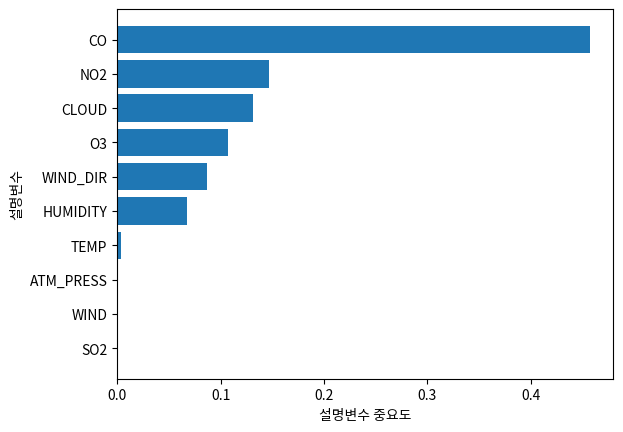

In [263]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 비가 오지 않을 때 

In [264]:
# 설명변수, 목표변수 데이터 지정
df_raw_x = df_air_RainNot_PM10.drop("PM10", axis = 1, inplace = False)
df_raw_y = df_air_RainNot_PM10["PM10"] 

# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.4, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [265]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncustomized.score (df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score (df_test_x, df_test_y)))

Accuracy on training set: 0.957
Accuracy on test set: 0.428


In [266]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경: 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]
# para_lr = [lr * 0.02 for lr in range(1, 20)]   # 민감하게 변화하면 0.02 간격으로 확인

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

In [267]:
# LearningRate별 정확도 테이블
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,0.957,0.428
1,0.2,0.993,0.430
2,0.3,0.999,0.393
3,0.4,1.000,0.373
4,0.5,1.000,0.401
5,0.6,1.000,0.242
6,0.7,1.000,0.337
7,0.8,1.000,0.344
8,0.9,1.000,0.238


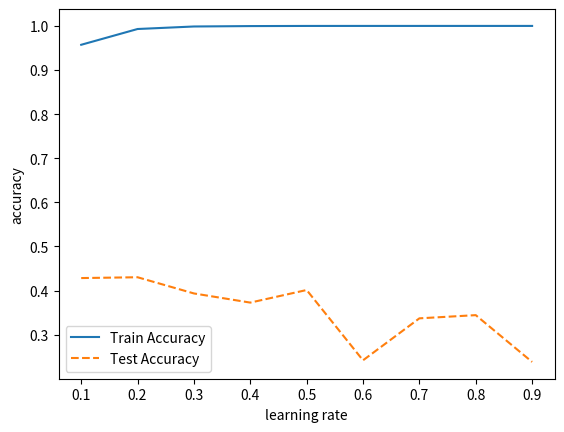

In [268]:
# LearningRate별 정확도 그래프로 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

In [269]:
# 학습률 지정
learing_rate = 0.3

In [270]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 10~150
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators = v_n_estimators, learning_rate=0.3, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [271]:
# n_estimators별 정확도 테이블
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.813,0.396
1,20,0.909,0.405
2,30,0.954,0.402
3,40,0.975,0.390
4,50,0.985,0.400
5,60,0.992,0.396
6,70,0.995,0.397
7,80,0.997,0.396
8,90,0.998,0.393
9,100,0.999,0.394


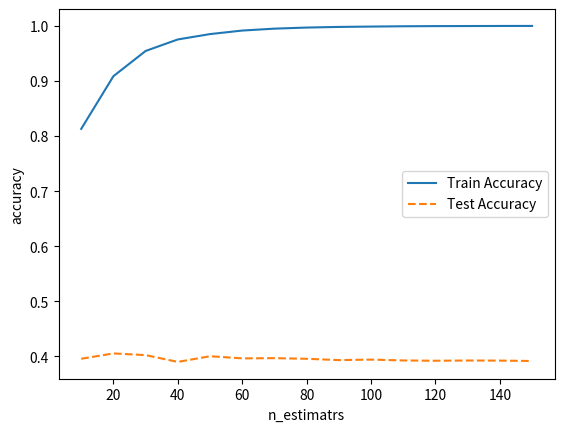

In [272]:
# 정확도를 그래프로 표현
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimatrs")
plt.legend()

In [273]:
# 트리 수 지정
n_estimators = 50

In [274]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경. 1~10
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(max_depth = v_max_depth,
                                    n_estimators=50, learning_rate=0.3, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [275]:
# max_depth별 정확도 테이블
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.648,0.416
1,2,0.910,0.463
2,3,0.985,0.400
3,4,0.998,0.324
4,5,1.000,0.313
5,6,1.000,0.326
6,7,1.000,0.254
7,8,1.000,0.220
8,9,1.000,0.159
9,10,1.000,0.106


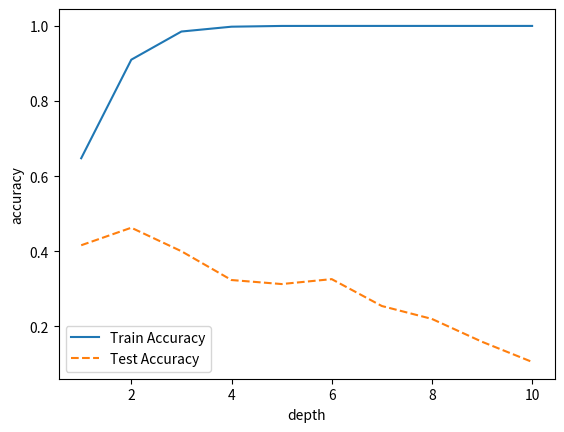

In [276]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

In [277]:
# 최대 깊이 지정
max_depth = 3

In [278]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수. 20~100
para_split = [n_split * 10 for n_split in range(2, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(min_samples_split = v_min_samples_split,
                                    max_depth=3, n_estimators=50, learning_rate=0.3, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [279]:
# min_samples_leaf별 정확도 테이블
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.967,0.442
1,30,0.960,0.462
2,40,0.940,0.459
3,50,0.931,0.478
4,60,0.923,0.425
5,70,0.915,0.409
6,80,0.908,0.455
7,90,0.905,0.451
8,100,0.889,0.438


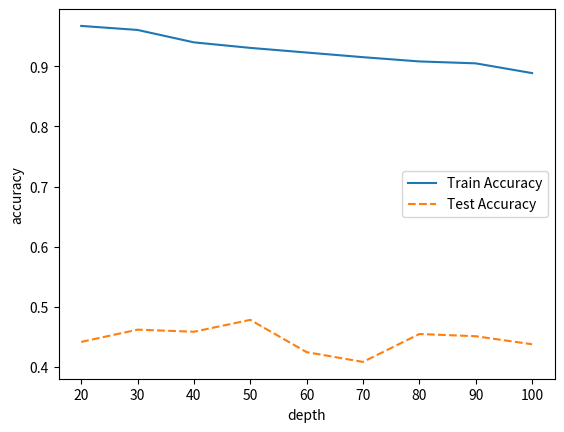

In [280]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

In [281]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 노드 최소 자료 수. 5~50
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(min_samples_leaf = v_min_samples_leaf,min_samples_split = 30,
                                     max_depth=3, n_estimators=50, learning_rate=0.3, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [282]:
# min_samples_leaf별 정확도 테이블
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.948,0.423
1,10,0.920,0.406
2,15,0.913,0.362
3,20,0.875,0.377
4,25,0.836,0.364
5,30,0.808,0.379
6,35,0.762,0.341
7,40,0.738,0.361
8,45,0.684,0.372
9,50,0.632,0.398


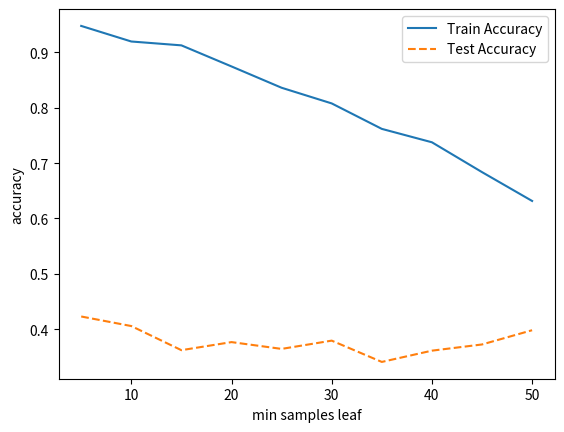

In [283]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()

In [284]:
# 잎사귀 노드의 최소 자료 수 지정
min_samples_leaf = 15

In [285]:
# 최종 모델
gb_final = GradientBoostingRegressor(min_samples_leaf=15, max_depth=3, n_estimators=50, learning_rate=0.3, min_samples_split = 30,
                                      random_state=1234)
gb_final.fit(df_train_x, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))

Accuracy on training set: 0.913
Accuracy on test set: 0.362



In [286]:
# 변수명
v_feature_name = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
2,CO,0.457
0,O3,0.109
4,TEMP,0.107
6,WIND_DIR,0.074
8,ATM_PRESS,0.072
9,CLOUD,0.064
5,WIND,0.042
7,HUMIDITY,0.037
1,NO2,0.036
3,SO2,0.003


Text(0, 0.5, '설명변수')

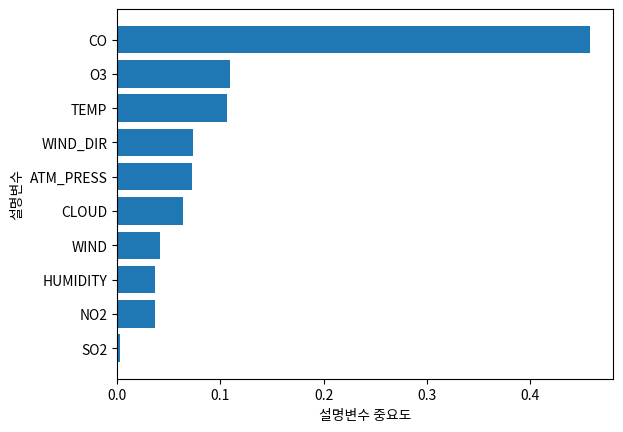

In [287]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")